In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm
import copy
from google.colab import files
import pickle

from torch.utils.data import TensorDataset, DataLoader

In [2]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 32
matplotlib.rcParams.update({'font.size': fontsize})
from matplotlib.pyplot import figure

In [3]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [4]:
!nvidia-smi

Tue May 16 21:33:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!mkdir sgd_images

mkdir: cannot create directory ‘sgd_images’: File exists


# Set-Up

In [6]:
# LENET parameters
RANDOM_SEED = 214748364
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 1000000
BATCH_SIZE = 250
BATCH_SIZE_TEST = 1000

EVAL = True

IMG_SIZE = 28
N_CLASSES = 10

#Set to zero to disconnect L2. 
weight_decay = 0.02

model_name = "inception"

In [7]:
dataset_name = "cifar"

In [8]:
from torchvision.models import resnet50

def createmodel(dropout):
  torch.cuda.manual_seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)
  if model_name == "inception":
    return InceptionNet(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "lenet":
    return LeNet5(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "alexnet":
    return AlexNet(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "mlp":
    return MLP(728,512,10, dropout=dropout)

# Data

In [9]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")

In [10]:
!nvidia-smi

Tue May 16 21:33:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.CenterCrop(IMG_SIZE),
                                             torchvision.transforms.Normalize((0., 0., 0.,), (1., 1., 1.)),
])

In [12]:
if dataset_name == "cifar":

    train_dataset = datasets.CIFAR10(root='cifar_data', 
                                    train=True, 
                                    transform=transforms,
                                    download=True)
    
    test_dataset = datasets.CIFAR10(root='cifar_data', 
                                    train=False, 
                                    transform=transforms)


Files already downloaded and verified


In [13]:
x_train = np.array([transforms(x).numpy() for x in train_dataset.data])
x_test = np.array([transforms(x).numpy() for x in test_dataset.data])
y_train = train_dataset.targets
y_test = test_dataset.targets

In [14]:

shape = x_train[0].shape

def permutation(x):
    rng = np.random.default_rng(1234)
    perm = rng.permutation(np.arange(shape[0]*shape[1]*shape[2]))
   
    return x.reshape(x.shape[0], -1)[:, perm].reshape(x.shape[0], x.shape[1], x.shape[2], x.shape[3])





In [15]:
x_train_perm = permutation(x_train)
x_test_perm = permutation(x_test)

In [16]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype = torch.float32),
                              torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(x_test,  dtype = torch.float32),
                             torch.tensor(y_test))

train_perm_dataset = TensorDataset(torch.tensor(x_train_perm,  dtype = torch.float32), 
                                   torch.tensor(y_train))
test_perm_dataset = TensorDataset(torch.tensor(x_test_perm,  dtype = torch.float32),
                                  torch.tensor(y_test))

In [17]:
def moving_average(a, n=3):
    border = np.floor(n/2).astype(int)
    new_a = np.zeros(len(a) + 2*border)
    new_a[:border] = a[0]
    new_a[-border:] = a[-1]
    new_a[border:-border] = a
    ret = np.cumsum(new_a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Model

In [18]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, n_channels, dropout = 0.0):
        super(LeNet5, self).__init__()
        torch.manual_seed(0)
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [19]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.0):
        super(MLP, self).__init__()
        self.dropout_value = dropout
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout_f = nn.Dropout(p=self.dropout_value, inplace = False)

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x


In [20]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes, input_channels, dropout = 0.0):
        super().__init__()
        
        self.dropout_value = dropout
        self.conv1 = ConvModule(in_channels =input_channels,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
        self.dropout_f = nn.Dropout(p=self.dropout_value, inplace = True)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.dropout_f(x)

        x = self.fc(x)
        return x

In [21]:
class AlexNet(nn.Module):

    def __init__(self, num_classes, input_channels, dropout = 0.0):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 192, kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),

            nn.Conv2d(192, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(256, 384),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(384, 192),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(192, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

# Code

In [22]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [23]:
#Binary Search for lambdas
def rate_function_BS(model, s_value, loader):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, loader)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):
  
  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [24]:
def eval_jensen(model, lambdas, loader):
  log_p = get_log_p(device, model, loader)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])


In [25]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0 
    losses = []
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses.append(loss.detach().cpu().numpy())
      
    return correct, total, np.mean(losses), np.var(losses)

In [26]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader, test_loader, lr):

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)

    data_iter = iter(train_loader)

    iters_per_epoch = len(data_iter)
    tq = tqdm(range(N_ITERS))

    aux_loss = 1

    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)

            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()



            tq.set_postfix({'Train cce': loss.detach().cpu().numpy()})


            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.015:
                print("Early-stopping")
                break
              aux_loss = 0


    return model

# Training

In [27]:
models = []
models.append(createmodel(dropout = 0.0).to(device))
models.append(createmodel(dropout = 0.0).to(device))


torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
models.append(MLP(3*28*28,512,10, dropout=0.0).to(device))

torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
models.append(MLP(3*28*28,512,10, dropout=0.0).to(device))

In [28]:
train_loaders = []
g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
train_loaders.append(torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
train_loaders.append(torch.utils.data.DataLoader(dataset=train_perm_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))


g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
train_loaders.append(torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))


g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
train_loaders.append(torch.utils.data.DataLoader(dataset=train_perm_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

In [29]:
test_loaders = []
g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
test_loaders.append(torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
test_loaders.append(torch.utils.data.DataLoader(dataset=test_perm_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))


g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
test_loaders.append(torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))


g_cuda = torch.Generator(device="cpu")
g_cuda.manual_seed(RANDOM_SEED)
test_loaders.append(torch.utils.data.DataLoader(dataset=test_perm_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True))

In [30]:
n_evals = [N_ITERS//1, N_ITERS//1, N_ITERS//1, N_ITERS//1]
labels = ["Inception", "Inception-Shuffle", "MLP", "MLP-Shuffle"]

In [31]:
print("Number of parameters: ", sum(p.numel() for p in models[0].parameters() if p.requires_grad))
print("Number of parameters: ", sum(p.numel() for p in models[-1].parameters() if p.requires_grad))

Number of parameters:  1814106
Number of parameters:  1735178


In [32]:
jet = plt.cm.get_cmap('Dark2')
colors = {
    "Inception": jet(0),
    "Inception-Shuffle": jet(1),
    "MLP": jet(2),
    "MLP-Shuffle": jet(3),
}
lrs = [0.001, 0.001, 0.1, 0.1]

<ipython-input-32-8ae4420ecd22>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Dark2')


In [33]:
markers = {
    "Inception": 8,
    "Inception-Shuffle": 9,
    "MLP": 10,
    "MLP-Shuffle": 11,
}

In [ ]:
for i in range(len(models)):
  setting_name=f"perm_{dataset_name}_{labels[i]}_lr_{str(lrs[i])}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}" 
  results = train(models[i], train_loaders[i], test_loaders[i], lr = lrs[i])
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 3600/1000000 [06:56<32:01:56,  8.64it/s, Train cce=0.010513493]


Early-stopping


  0%|          | 3000/1000000 [05:46<31:57:25,  8.67it/s, Train cce=0.019981224]


Early-stopping


  2%|▏         | 18000/1000000 [02:19<2:07:13, 128.64it/s, Train cce=0.015670288]


Early-stopping


  2%|▏         | 20200/1000000 [08:51<7:09:37, 38.01it/s, Train cce=0.013858505]


Early-stopping


In [34]:
BATCH_LOSS=0
TRAIN_LOSS=1
TEST_LOSS=2
VARIANCE=3
MODELS=4
train_loss = [BATCH_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS] 

# Figure 1: Train & Test Evolution

In [35]:
models_id = [0,1,2,3]

In [37]:
results = []
for i in models_id:
    setting_name=f"perm_{dataset_name}_{labels[i]}_lr_{str(lrs[i])}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}" 
    with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
      results.append(pickle.load(handle))

In [ ]:
for i in models_id:
  print(labels[i])
  correct, total, cce, _ = eval(device, results[i], train_loaders[i], criterion)
  print("\tTrain acc: ", correct/total)
  print("\tTrain cce: ", cce)
  correct, total, cce, _ = eval(device, results[i], test_loaders[i], criterion)
  print("\tTest acc: ", correct/total)
  print("\tTest cce: ", cce)


Inception
	Train acc:  1.0
	Train cce:  0.009399094
	Test acc:  0.7408
	Test cce:  1.007815
Inception-Shuffle
	Train acc:  1.0
	Train cce:  0.009237531
	Test acc:  0.4246
	Test cce:  2.453498
MLP
	Train acc:  0.99998
	Train cce:  0.014745784
	Test acc:  0.5169
	Test cce:  3.294686
MLP-Shuffle
	Train acc:  0.99996
	Train cce:  0.014838463
	Test acc:  0.5112
	Test cce:  3.291436


In [ ]:
import matplotlib.pyplot as plt

# Figure 4: Jensen-Gap Functions Evolution

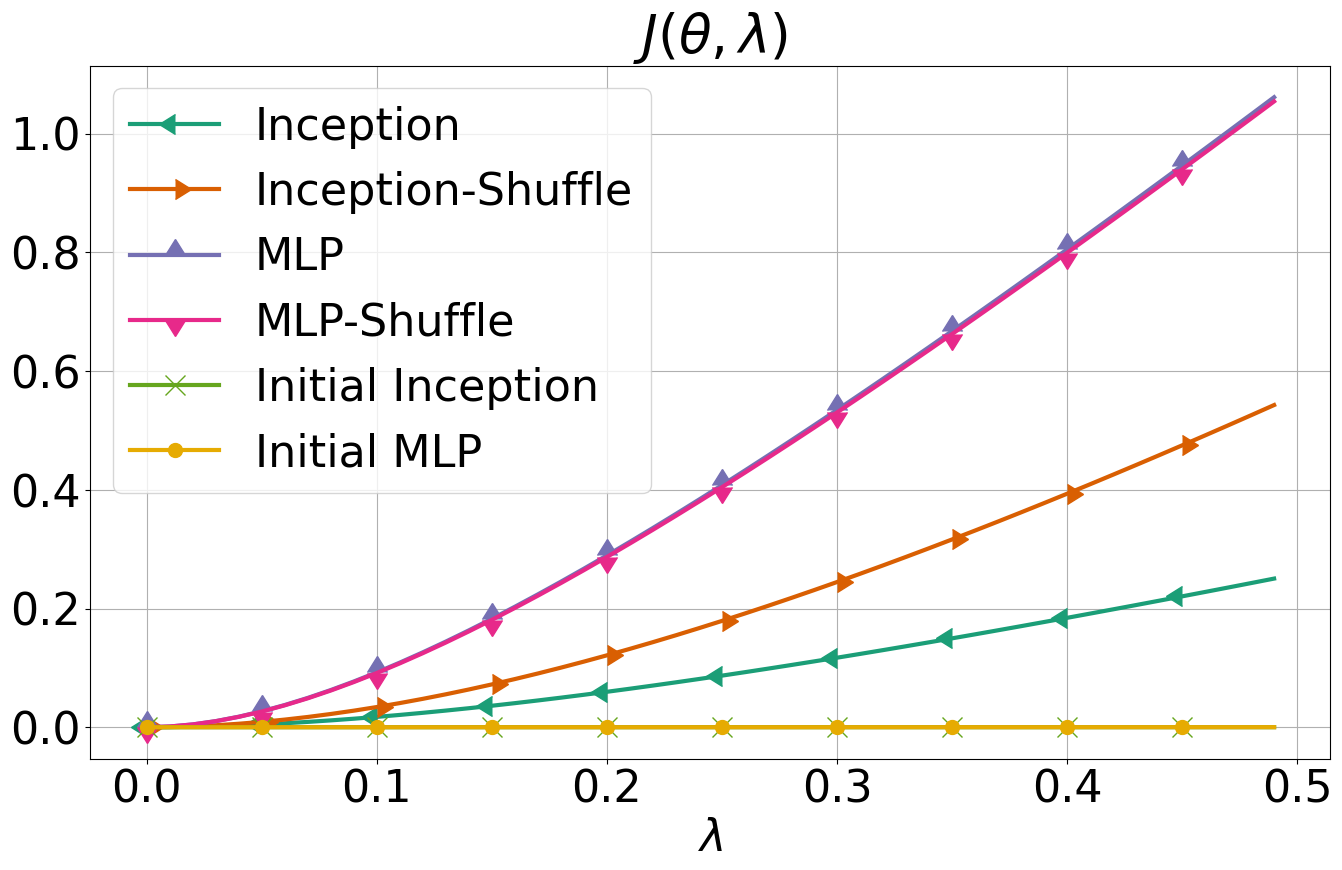

In [ ]:
lambdas = np.arange(0, 0.5, 0.01)


for i in models_id:
  jensen = eval_jensen(results[i].to(device), lambdas, test_loaders[i])
  plt.plot(lambdas, jensen, label=labels[i],linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=5)



jensen1 = eval_jensen(initial_mocel, lambdas, test_loaders[0])
plt.plot(lambdas, jensen1, label = "Initial Inception",linewidth=3, color = jet(4), marker = "x",  markersize=15, markevery=5)


jensen1 = eval_jensen(initial_mlp, lambdas, test_loaders[0])
plt.plot(lambdas, jensen1, label = "Initial MLP",linewidth=3, color = jet(5), marker = "o",  markersize=10, markevery=5)


plt.legend()
#plt.xlim(0,0.5)
#plt.ylim(0,0.3)
plt.xlabel(r"$\lambda$")
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [38]:
rates = []
s_values = np.arange(0, 0.5, 0.01)

for i in models_id:
  print(i)
  rates.append(np.array([rate_function_BS(results[i].to(device), s,  test_loaders[i])[0] for s in s_values]))

0
1
2
3


In [39]:
initial_mocel = createmodel(dropout = 0.0).to(device)


torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
initial_mlp = MLP(3*28*28,512,10, dropout=0.0).to(device)
rate_initial_mlp = np.array([rate_function_BS(initial_mlp.to(device), s,  test_loaders[0])[0] for s in s_values])
rate_initial = np.array([rate_function_BS(initial_mocel.to(device), s, test_loaders[0])[0] for s in s_values])

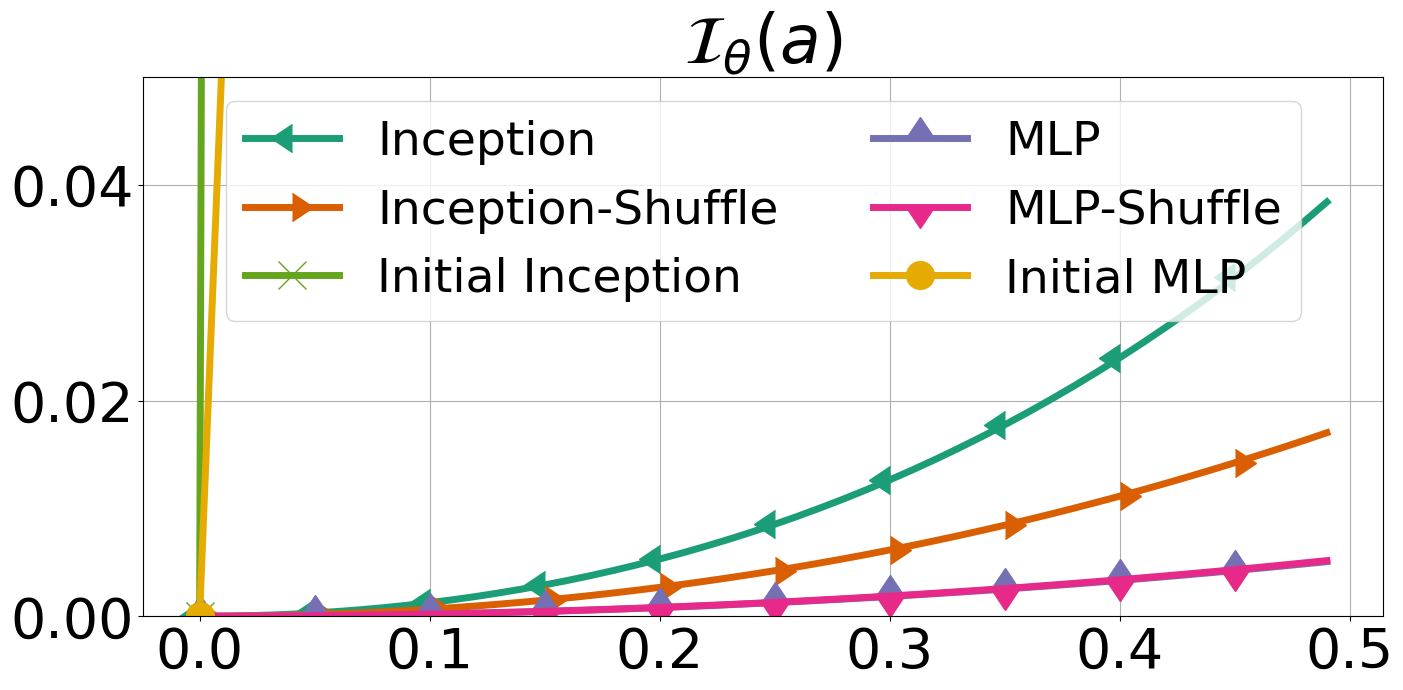

In [71]:
plt.rcParams['figure.figsize'] = (16, 7)
fontsize = 40
matplotlib.rcParams.update({'font.size': fontsize})


plt.plot(s_values, rates[0], label=labels[0],linewidth=5, color = colors[labels[0]], marker = markers[labels[0]],  markersize=20, markevery=5)
plt.plot(s_values, rates[1], label=labels[1],linewidth=5, color = colors[labels[1]], marker = markers[labels[1]],  markersize=20, markevery=5)
plt.plot(s_values, rate_initial, label = "Initial Inception",linewidth=5, color = jet(4), marker = "x",  markersize=20, markevery=5)

plt.plot(s_values, rates[2], label=labels[2],linewidth=5, color = colors[labels[2]], marker = markers[labels[2]],  markersize=20, markevery=5)
plt.plot(s_values, rates[3], label=labels[3],linewidth=5, color = colors[labels[3]], marker = markers[labels[3]],  markersize=20, markevery=5)

plt.plot(s_values, rate_initial_mlp, label = "Initial MLP",linewidth=5, color = jet(5), marker = "o",  markersize=20, markevery=5)

plt.legend(fontsize=50, loc = "upper center", ncol = 2,prop={'size':34})
plt.ylim(0,0.05)
plt.grid()
plt.title(r"$\mathcal{I}_{\theta}(a)$")
plt.savefig("sgd_images/rate.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Figure 5: Rates Evolution



Compute Rates

In [ ]:
for i in range(len(models)):
  setting_name=f"perm_{dataset_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}_rates" 
  rates = []
  for j in tqdm(range(len(results[i][TEST_LOSS]))):
    rates.append(rate_function_BS(results[i][MODELS][j].to(device), results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j], test_loaders[i]))
  with open(f'sgd_images/{setting_name}_rates.pickle', 'wb') as handle:
    pickle.dump(rates, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load and Figures

In [ ]:
rates = []

for i in range(len(models)):
  setting_name=f"perm_{dataset_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}_rates" 
  with open(f"sgd_images/{setting_name}_rates.pickle", "rb") as handle:
    rates.append(pickle.load(handle))

In [ ]:
for i in models_id:
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))]
  plt.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
  plt.plot(iters_number[i], moving_average(a, 5), label=labels[i],  color = colors[labels[i]],linewidth=2.5)

plt.legend(fontsize=20, prop={'size': 26})
#plt.xlim(100,2500)
plt.ylim(0, 100)
plt.grid()
plt.hlines(np.log(1/0.01),0,N_ITERS)
plt.title(r"$\alpha(\theta_t,B_t)$")
plt.savefig("sgd_images/rates.pdf", format = "pdf",bbox_inches='tight') 
plt.show()


In [ ]:
# create the first plot
fig, ax1 = plt.subplots()
i=0
offset = 5
a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))][offset:]
ax1.plot(iters_number[i][offset:], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
ax1.plot(iters_number[i][offset:], moving_average(a, 5), label=labels[i], color = colors[labels[i]],linewidth=2.5)
ax1.set_xlabel('Iteration')
ax1.set_xlim(100,2500)
#ax1.tick_params('y', colors='g')
plt.legend(fontsize=20, prop={'size': 26})

# create the second plot
ax2 = ax1.twinx()
for i in range(1,len(models)):
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))]
  ax2.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
  ax2.plot(iters_number[i], moving_average(a, 11),label=labels[i], color = colors[labels[i]],linewidth=2.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(100,2500)
plt.legend(fontsize=20, prop={'size': 26})


plt.hlines(np.log(1/0.01),0,N_ITERS)
plt.title(r"$\alpha(\theta_t,B_t)$")
plt.savefig("sgd_images/rates.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [ ]:
# create the first plot
fig, ax1 = plt.subplots()
i=0
offset = 5
a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))][offset:]
ax1.plot(iters_number[i][offset:], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
ax1.plot(iters_number[i][offset:], moving_average(a, 5), label=labels[i], color = colors[labels[i]],linewidth=2.5)
ax1.set_xlabel('Iteration')
ax1.set_xlim(100,2500)
#ax1.set_ylim(-30,300)
ax1.set_ylabel(r'$r(\theta_t,D)$')
#ax1.tick_params('y', colors='g')
plt.legend(fontsize=20, prop={'size': 26})

# create the second plot
ax2 = ax1.twinx()
for i in range(1,len(models)):
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))]
  ax2.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
  ax2.plot(iters_number[i], moving_average(a, 11),label=labels[i], color = colors[labels[i]],linewidth=2.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(100,2500)
ax2.set_ylabel(r'$r(\theta_t,B_t)$')
plt.legend(fontsize=20, prop={'size': 26})


# show the plot
plt.title(r"$r(\theta_t,B_t)$")
plt.grid()
plt.hlines(np.log(1/0.01),0,N_ITERS,linewidth=2.5)

plt.savefig("sgd_images/rates_two_axes.pdf", format = "pdf",bbox_inches='tight')
plt.show()



In [ ]:
np.log(1/0.01)


# Figure 6: KLs Evolution





In [ ]:
for i in models_id:
  vec = [rates[i][j][2] for j in range(len(rates[i]))]
  plt.plot(iters_number[i], vec, alpha = 0.2, color = colors[labels[i]], linewidth=2.5)
  plt.plot(iters_number[i], moving_average(vec, 5), label=labels[i], color = colors[labels[i]], linewidth=2.5)

plt.legend(fontsize=20, prop={'size': 26})
#plt.ylim(0,400)
plt.xlim(100,N_ITERS)
#plt.xlim(0,250)
plt.title(r"$KL(\nu, \nu p^{\lambda})$")
plt.grid()
plt.savefig("sgd_images/KL.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [ ]:
for i in models_id:
  vec = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))]
  plt.hist(vec,density=True)
  # Plot density
  lambda_rate=1
  x = np.linspace(0, np.log(1.0/0.01)/lambda_rate, 1000)
  y = lambda_rate *np.exp(-lambda_rate * x)
  plt.plot(x, y, color='red')
  plt.plot(-x, y, color='red')
  plt.savefig(f"sgd_images/hist_{labels[i]}.pdf", format = "pdf",bbox_inches='tight') 
  plt.show()


In [ ]:
#Acceptance rate
for i in range(len(models)):
  vec = np.array([rates[i][j][0]*BATCH_SIZE for j in range(len(rates[i]))])
  print(np.mean(np.random.uniform(0,1,vec.shape[0])<np.exp(-vec)))

# Figure 7: Rates Limit

In [ ]:
#rates_batch_lim = []
#for i in range(len(models)):
#  rates_batch_lim.append([rate_function_BS(results[i][MODELS][j], results[i][TEST_LOSS][j] - 0.01)[0] for j in tqdm(range(len(results[i][MODELS])))])


In [ ]:
#with open(f'sgd_images/{setting_name}_rates_lim.pickle', 'wb') as handle:
#  pickle.dump(rates_batch_lim, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open(f"sgd_images/{setting_name}_rates_lim.pickle", "rb") as handle:
#  rates_batch_lim = pickle.load(handle)

In [ ]:
#for i in models_id:
#  plt.plot(iters_number, np.array(rates_batch_lim[i]), label=labels[i])
#  plt.plot(iters_number, [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))], label=labels[i])

#plt.legend()
#plt.grid()
#plt.ylim(0,1)
#plt.xlim(0,N_ITERS)
#plt.title("Rate Lim-0.01")


# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*

In [ ]:
files.download('sgd_images/images.zip')

In [ ]:
!ls -l sgd_images